# Collimation lines processing

This notebook is used to demonstrate a way to correct some distortion in a KH-9 PC images which use the collimation lines.

Note:
- the KH-9 PC image must be joined before the processing
- the total time of processing one image is around 3 min

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import hipp

In [5]:
raster_filepath = "/home/godinlu/Documents/github/ship/hipp/notebooks/data/kh9pc/joined_images/D3C1214-100097A015.tif"
#raster_filepath = "/home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/joined_images/D3C1214-100097F012.tif"
#raster_filepath = "/home/godinlu/Documents/github/ship/hipp/notebooks/data/kh9pc/joined_images/D3C1214-100097A014.tif"


## Detect the top and bottom collimation lines

The detection of those collimation lines is divided into 3 majors steps:
1. **Image opening**: Open only concern window of images and apply a horizontal stride to reduce noise and computing time.
2. **Light peaks detection**: detect all light peaks verticaly
3. **RANSAC fitting**: Fit a 2nd degree polynom with RANSAC on the peaks coordinates


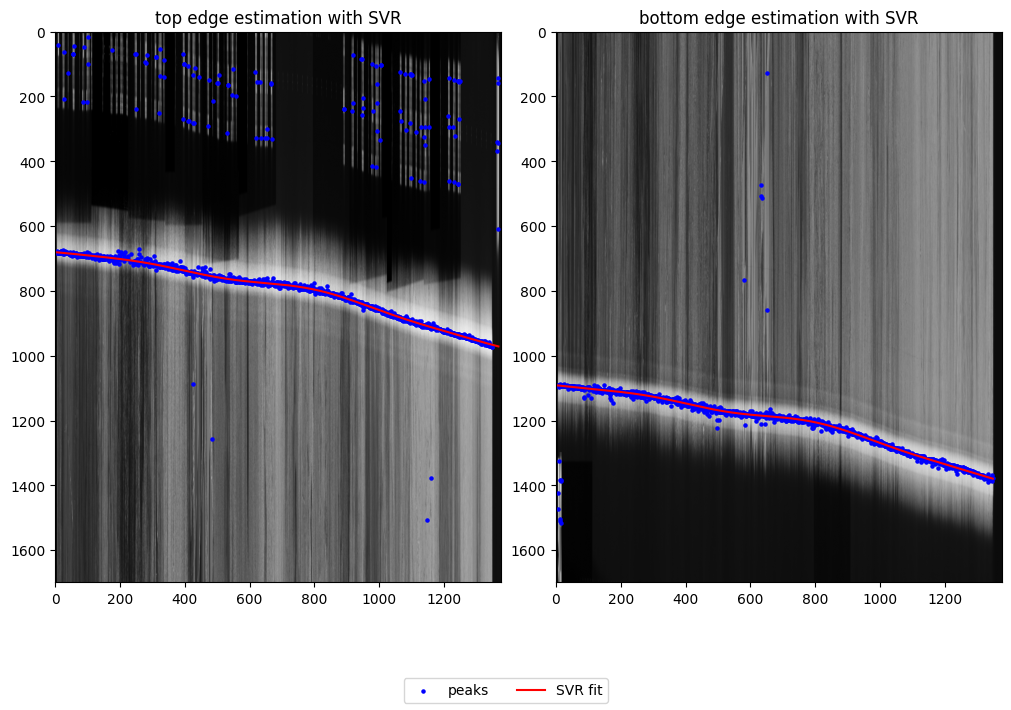

In [6]:
collimation_lines = hipp.kh9pc.lines_processing.detect_horizontal_collimation_lines(raster_filepath)

## Detect the left and right edges

The detection of those edges follow a similar process:
1. **Image opening**: Open only concern window of images and apply a vertical stride to reduce noise and computing time.
2. **Light rupture detection**: scanning from the left or right to find the first pixels above the `px_threshold` (default : 20).
3. **RANSAC vertical fitting**: Fit a constant estimator with RANSAC to find the x values of the left and right edges.


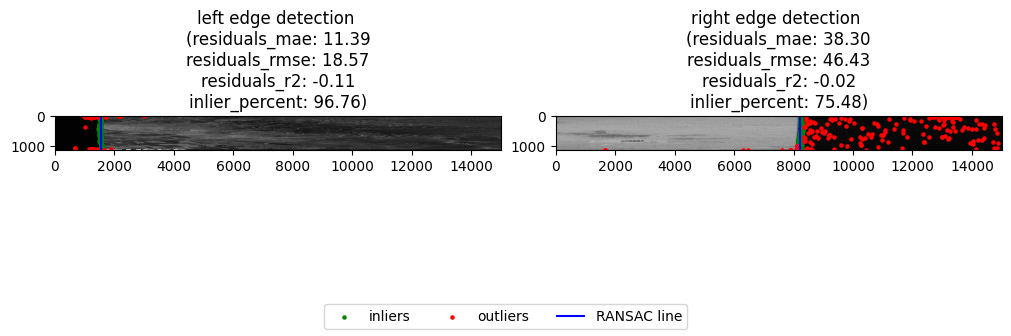

In [7]:
vertical_edges = hipp.kh9pc.lines_processing.detect_vertical_edges(raster_filepath)

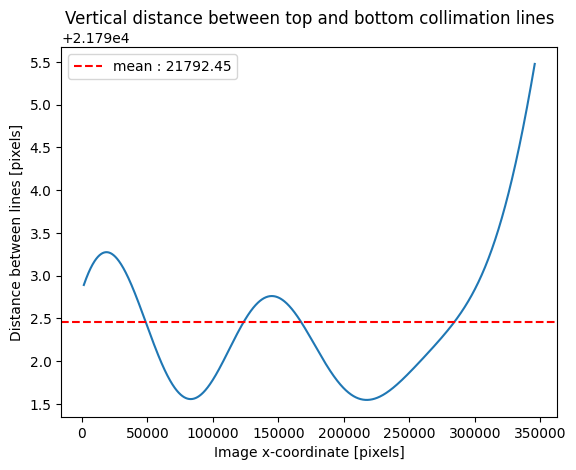

In [8]:
hipp.kh9pc.lines_processing.plot_distance_between_collimation_lines(vertical_edges, collimation_lines)

## Compute the affine transformation to correct image distortion

To estimate the affine transformation, we need a set of source and destination control points.  

- **Source points:** sampled along the two detected polynomial fits, using x-values spanning the interval between the left and right detected edges of the image.  
- **Destination points:** constructed as two straight horizontal lines. The top line has y = 0, and the bottom line has y = `colimation_line_dist` (default: 21 771, derived from a 7 µm scan resolution and a theoretical 6-inch spacing between collimation lines).  

This setup allows the affine transformation to map the distorted collimation lines in the scanned image to their expected ideal positions.  


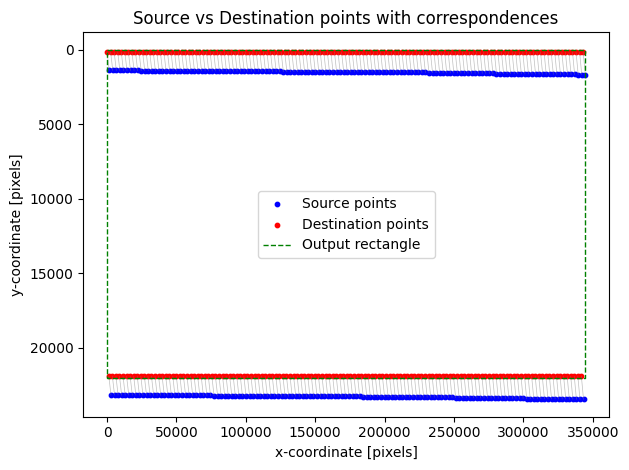

In [14]:
tf_matrix, output_img_size, dists = hipp.kh9pc.lines_processing.compute_transformation(vertical_edges, collimation_lines)

In [16]:
output_img_size

(344094, 22064)

## The warp the image with the Affine transform and the good output size

This function can take some time, 2 min on my machine.

In [12]:
hipp.image.warp_raster_pixels(raster_filepath, "test.tif", tf_matrix, output_img_size)

## Control the output image

Here we can see the image is correctly cropped on the collimation line.
We can see the collimation is still curved cause of the affine transformation. But now both collimation line are aligned with x-axis. 

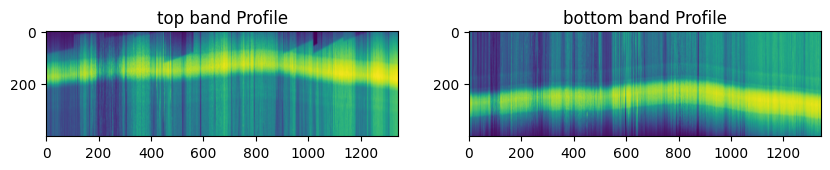

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10,8))
for i, side in enumerate(["top", "bottom"]):
    band, _ = hipp.kh9pc.lines_processing.extract_raster_band_slice("test.tif", (0,0), band_size=400, stride=256, side=side)
    axes[i].imshow(band)
    axes[i].set_title(f"{side} band Profile")

plt.show()


## 